# Granite Function Calling Agent

In this recipe, you will use the IBM® [Granite](https://www.ibm.com/granite) model now available on watsonx.ai™ to perform custom function calling.  

Traditional [large language models (LLMs)](https://www.ibm.com/topics/large-language-models), like the OpenAI GPT-5 (generative pre-trained transformer) model available through ChatGPT, and the IBM Granite™ models that we'll use in this recipe, are limited in their knowledge and reasoning. They produce their responses based on the data used to train them and are difficult to adapt to personalized user queries. To obtain the missing information, these [generative AI](https://www.ibm.com/topics/generative-ai) models can integrate external tools within the function calling. This method is one way to avoid fine-tuning a foundation model for each specific use-case. The function calling examples in this recipe will implement external [API](https://www.ibm.com/topics/api) calls. 

The Granite model and tokenizer use [natural language processing (NLP)](https://www.ibm.com/topics/natural-language-processing) to parse query syntax. In addition, the models use function descriptions and function parameters to determine the appropriate tool calls. Key information is then extracted from user queries to be passed as function arguments. 

# Steps

## Step 1. Set up your environment

While you can choose from several tools, this recipe is best suited for a Jupyter Notebook. Jupyter Notebooks are widely used within data science to combine code with various data sources such as text, images and data visualizations. 

You can run this notebook in [Colab](https://colab.research.google.com/), or download it to your system and [run the notebook locally](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Getting_Started_with_Jupyter_Locally/Getting_Started_with_Jupyter_Locally.md). 

To avoid Python package dependency conflicts, we recommend setting up a [virtual environment](https://docs.python.org/3/library/venv.html).

Note, this notebook is compatible with Python 3.12 and well as Python 3.11, the default in Colab at the time of publishing this recipe. To check your python version, you can run the `!python --version` command in a code cell.


## Step 2. Set up a watsonx.ai instance

See [Getting Started with IBM watsonx](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Getting_Started/Getting_Started_with_WatsonX.ipynb) for information on getting ready to use watsonx.ai. 

You will need three credentials from the watsonx.ai set up to add to your environment: `WATSONX_URL`, `WATSONX_APIKEY`, and `WATSONX_PROJECT_ID`.

## Step 3. Install relevant libraries and set up credentials and the Granite model

We'll need a few libraries for this recipe. We will be using LangGraph and LangChain libraries to use Granite on watsonx.ai.

In [1]:
! echo "::group::Install Dependencies"
%pip install uv
! uv pip install "git+https://github.com/ibm-granite-community/utils.git" \
    langgraph \
    langchain \
    langchain_ibm
! echo "::endgroup::"

::group::Install Dependencies
Note: you may need to restart the kernel to use updated packages.
Using Python 3.12.4 environment at: /Users/aakritiaggarwal/Documents/cookbook/.venv
Resolved 49 packages in 2.55s                                        
Audited 49 packages in 1ms
::endgroup::


Now we will get the credentials to use watsonx.ai and create the Granite model for use.

<!-- WATSONX_URL=https://eu-de.ml.cloud.ibm.com
WATSONX_APIKEY=NN0oeSkAgUWb5SWrc7kXsqwnj2zkh3AgmX64K7cUiX32
WATSONX_PROJECT_ID=f45e05e8-535a-4cc5-b51c-f7b3cf520943 -->

In [2]:
!pip install langchain

In [3]:
from ibm_granite_community.notebook_utils import get_env_var
from langchain_core.utils.utils import convert_to_secret_str
from langchain.chat_models import init_chat_model
from langchain_openai import ChatOpenAI, OpenAI

model = "ibm/granite-4-h-small"

model_parameters = {
    "temperature": 0,
    "max_completion_tokens": 200,
    "repetition_penalty": 1.05,
}

# llm = init_chat_model(
#     model=model,
#     model_provider="ibm",
#     base_url="https://inference-3scale-apicast-production.apps.rits.fmaas.res.ibm.com/granite-4-8b/v1",
#     default_headers={"RITS_API_KEY": "fb86f7e3c7d04ec083157e4358e6b37b"},
#     params=model_parameters,
# )

llm_granite = ChatOpenAI(
    model_name="ibm-granite/granite-4.0-8b",
    api_key="not-needed",
    base_url="https://inference-3scale-apicast-production.apps.rits.fmaas.res.ibm.com/granite-4-8b/v1",
    default_headers={"RITS_API_KEY": "fb86f7e3c7d04ec083157e4358e6b37b"},
    temperature=0.0,  # matches what Concert agent uses
)

## Step 4: Define the functions

We define two functions to be used as tools by our agent. These functions can use real web API if you obtain the necessary API keys. If you are unable to get the API keys, the tools below will respond with a fixed, predetermined value for demonstration purposes.

The `get_stock_price` function in this recipe use an `AV_STOCK_API_KEY` key. To generate a free `AV_STOCK_API_KEY`, please visit the [Alpha Vantage website](https://www.alphavantage.co/support/#api-key). 

Secondly, the `get_current_weather` function uses a `WEATHER_API_KEY`. To generate one, please [create an account](https://home.openweathermap.org/users/sign_up). Upon creating an account, select the "API Keys" tab to display your free key.

**Store these private keys in a separate `.env` file in the same level of your directory as this notebook.**

In [4]:
AV_STOCK_API_KEY = convert_to_secret_str(get_env_var("AV_STOCK_API_KEY", "6GRX8LDPIPYLAP2X"))

WEATHER_API_KEY = convert_to_secret_str(get_env_var("WEATHER_API_KEY", "22f1103155f90f157576e342693b67ea"))

We can now define our functions. The function's docstring and type information are important for generating the proper tool information since this information will be the basis of the tool description provided to the model.

In this recipe, the `get_stock_price` function uses the Stock Market Data API available through Alpha Vantage. 

In [5]:
import requests

def get_stock_price(ticker: str, date: str) -> dict:
    """
    Retrieves the lowest and highest stock prices for a given ticker and date.

    Args:
        ticker: The stock ticker symbol, for example, "IBM".
        date: The date in "YYYY-MM-DD" format for which you want to get stock prices.

    Returns:
        A dictionary containing the low and high stock prices on the given date.
    """
    print(f"Getting stock price for {ticker} on {date}")

    apikey = AV_STOCK_API_KEY.get_secret_value()
    if apikey == "unset":
        print("No API key present; using a fixed, predetermined value for demonstration purposes")
        return {
            "low": "245.4500",
            "high": "249.0300"
        }

    try:
        stock_url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={ticker}&apikey={apikey}"
        stock_data = requests.get(stock_url)
        data = stock_data.json()
        stock_low = data["Time Series (Daily)"][date]["3. low"]
        stock_high = data["Time Series (Daily)"][date]["2. high"]
        return {
            "low": stock_low,
            "high": stock_high
        }
    except Exception as e:
        print(f"Error fetching stock data: {e}")
        return {
            "low": "none",
            "high": "none"
        }


The `get_current_weather` function retrieves the real-time weather in a given location using the Current Weather Data API via [OpenWeather](https://openweathermap.org/api). 

In [6]:
def get_current_weather(location: str) -> dict:
    """
    Fetches the current weather for a given location (default: San Francisco).

    Args:
        location: The name of the city for which to retrieve the weather information.

    Returns:
        A dictionary containing weather information such as temperature in celsius, weather description, and humidity.
    """
    print(f"Getting current weather for {location}")
    apikey=WEATHER_API_KEY.get_secret_value()
    if apikey == "unset":
        print("No API key present; using a fixed, predetermined value for demonstration purposes")
        return {
            "description": "thunderstorms",
            "temperature": 25.3,
            "humidity": 94
        }

    try:
        # API request to fetch weather data
        weather_url = f"https://api.openweathermap.org/data/2.5/weather?q={location}&appid={apikey}&units=metric"
        weather_data = requests.get(weather_url)
        data = weather_data.json()
        # Extracting relevant weather details
        weather_description = data["weather"][0]["description"]
        temperature = data["main"]["temp"]
        humidity = data["main"]["humidity"]

        # Returning weather details
        return {
            "description": weather_description,
            "temperature": temperature,
            "humidity": humidity
        }
    except Exception as e:
        print(f"Error fetching weather data: {e}")
        return {
            "description": "none",
            "temperature": "none",
            "humidity": "none"
        }


## Step 4: Build the agent

Now we use LangGraph to build the agent. First we setup the agent's state. The state is maintained by the agent as it handles a request. This state will hold the list of messages in the multi-turn conversation with the model.

In [7]:
from typing import Annotated, TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class State(TypedDict, total=False):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list[AnyMessage], add_messages]


We now create a binding of the tools to the Granite model. When the model is called, the available tool descriptions are provided to the model.

In [8]:
tools = [get_stock_price, get_current_weather]
llm_with_tools = llm_granite.bind_tools(tools)

Now we begin to create the LangGraph graph for our agent. This graph consists of nodes which are functional blocks which are assembled into a graph with edges controlling workflow through the graph from a start node to an end node.

The first node we create is for calling Granite. It uses the list of messages from the state as the input to the model and returns the response message from the model to update the state.

In [9]:
def llm_node(state: State) -> State:
    messages = state["messages"]
    response_message = llm_with_tools.invoke(messages)
    state_update = State(messages=[response_message])
    return state_update


We also want a node for tool calling when the model requests a tool be called with some arguments. Here we use the pre-built tool calling node implementation from LangGraph.

When the model wants to use a provided tool, it will request the tool name along with arguments. The tool node will call the tool with the arguments and add a tool message to the state with the results of the tool call.

In [10]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools=tools)

We also need some edges defined to control flow between the nodes we created.

We define a function to examine the state and decide whether to call to the tool node if Granite requested to use a tool or proceed to the END node in the graph finishing the workflow. 

In [11]:
from langchain_core.messages import AIMessage
from langgraph.graph import END

def route_tools(state: State) -> str:
    """
    This is conditional_edge function to route to the ToolNode if the last message
    in the state has tool calls. Otherwise, route to the END node to complete the
    workflow.
    """
    messages = state.get("messages")
    if not messages:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    last_message = messages[-1]
    # If the last message is from the model and it contains a tool call request
    if isinstance(last_message, AIMessage) and len(last_message.tool_calls) > 0:
        return "tools"
    return END

We now have defined some nodes and a function to act as an edge. 

Next we build the graph using the nodes and add edges between the nodes.

In [12]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(State)

We add two nodes. One for our llm node and another for our tools node.

The first argument is the unique node name. The second argument is the function or object that will be called whenever the node is used.

In [13]:
graph_builder.add_node("llm", llm_node)
graph_builder.add_node("tools", tool_node)


Then we add the initial edge from the `START` node to our llm node. This starts the workflow.

In [14]:
from langgraph.graph import START

graph_builder.add_edge(START, "llm")

Then we add a conditional edge from our llm node to either our tools node
or the final `END` node. The `route_tools` function we define above returns `tools` if the llm asks to use a tool,
and `END` if no tool call is requested.
This conditional routing defines the main agent loop.

In [15]:
graph_builder.add_conditional_edges(
    "llm",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {
        "tools": "tools",
        END: END,
    },
)


We then add an edge so that after a tool has been called, we return to our llm node to decide the next step.

In [16]:
graph_builder.add_edge("tools", "llm")

Now that we have added all the nodes and edges to the builder, we compile this into our graph.

In [17]:
from langgraph.graph.state import CompiledStateGraph

graph: CompiledStateGraph[State] = graph_builder.compile()

We can visualize the compiled graph to see the nodes and edges in the graph.

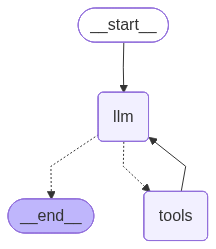

In [18]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Step 5: Using the agent

To use our agent, we define a method to process a request to the agent. The input is processed by the agent's graph and the event stream of messages processed by the agent is displayed so we can see the workflow of the agent.

In [19]:
from langchain_core.messages import HumanMessage

def function_calling_agent(graph: CompiledStateGraph, user_input: str):
    user_message = HumanMessage(user_input)
    print(user_message.pretty_repr())
    input = State(messages=[user_message])
    for event in graph.stream(input):
        for value in event.values():
            print(value["messages"][-1].pretty_repr())

Let's ask some questions of the agent which rely upon using the provided tools.

In [20]:
function_calling_agent(graph, "What is the weather in Miami?")

================================ Human Message =================================

What is the weather in Miami?
================================== Ai Message ==================================
Tool Calls:
  get_current_weather (chatcmpl-tool-52998382f2554819beb8244d66e9f30e)
 Call ID: chatcmpl-tool-52998382f2554819beb8244d66e9f30e
  Args:
    location: Miami
Getting current weather for Miami
================================= Tool Message =================================
Name: get_current_weather

{"description": "clear sky", "temperature": 4.06, "humidity": 77}
================================== Ai Message ==================================

The current weather in Miami is clear sky with a temperature of 4.06°C and humidity of 77%.


In [21]:
function_calling_agent(graph, "What were the IBM stock prices on September 5, 2025?")

================================ Human Message =================================

What were the IBM stock prices on September 5, 2025?
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (chatcmpl-tool-9fa90a8358404553b77d51b553115098)
 Call ID: chatcmpl-tool-9fa90a8358404553b77d51b553115098
  Args:
    ticker: IBM
    date: 2025-09-05
Getting stock price for IBM on 2025-09-05
Error fetching stock data: '2025-09-05'
================================= Tool Message =================================
Name: get_stock_price

{"low": "none", "high": "none"}
================================== Ai Message ==================================

I'm sorry, but I couldn't find the stock prices for IBM on September 5, 2025. The data might not be available or there might be an issue with the request. Please try again later or check the date and ticker symbol for accuracy.


## Step 6: Simplifying your agent creation

LangChain provides a method to that captures all of the work we did above to create a function calling agent. You just need to provide the model and the list of tools.

In [22]:
from langchain.agents import create_agent

agent = create_agent(
    model=llm_granite,
    tools=tools,
)

function_calling_agent(agent, "What is the weather in Miami?")

================================ Human Message =================================

What is the weather in Miami?
================================== Ai Message ==================================
Tool Calls:
  get_current_weather (chatcmpl-tool-0040652e8a4e42768f8f979867ac78d8)
 Call ID: chatcmpl-tool-0040652e8a4e42768f8f979867ac78d8
  Args:
    location: Miami
Getting current weather for Miami
================================= Tool Message =================================
Name: get_current_weather

{"description": "clear sky", "temperature": 4.06, "humidity": 77}
================================== Ai Message ==================================

The current weather in Miami is clear sky with a temperature of 4.06°C and humidity of 77%.


A note about the `prompt` argument to `create_agent`. Not specifying the `prompt` argument means the agent will behave as a function calling agent that we previously built above. The `prompt` argument is used as a system prompt to the model. For Granite 3, providing a system prompt will mean the default system prompt for tool calling will be not be present and the model may not properly handle tool calling. So we do not specify the `prompt` argument here.

# Testing Your Agent

Now that we have built a function-calling agent, let's create a structured test framework to evaluate its behavior. Testing agents is essential because:

- **Catch regressions early** when you update prompts, tool schemas, or models.
- **Compare alternatives objectively** (e.g., model A vs. model B).
- **Ship with confidence** because you know core use cases still pass.

We'll implement:
1. Evaluation helpers for tool-call trajectories and responses
2. Structured test cases
3. Single-turn and multi-turn testing
4. Summary metrics tracking

## Step 7: Define data structures and evaluation helpers

Before running tests, we define how to evaluate agent outputs. This follows TDD principles: write your assertions first.

We need two types of evaluation:
- **Trajectory evaluation**: Did the agent call the right tools with the right parameters?
- **Response evaluation**: Did the agent's final response contain the expected content?

In [23]:
from dataclasses import dataclass, field
from typing import Any, Dict, List
import time


@dataclass
class ToolCall:
    """Represents a single tool call made by the agent."""
    tool_name: str
    tool_parameters: Dict[str, Any]


@dataclass
class AgentTestResult:
    """The output of an agent test run, including tool calls and metrics."""
    tool_calls: List[ToolCall] = field(default_factory=list)
    final_response: str = ""
    latency_ms: float = 0.0
    prompt_tokens: int = 0
    response_tokens: int = 0
    total_tokens: int = 0


def trajectory_match(actual: List[ToolCall], expected: List[Dict[str, Any]]) -> bool:
    """Check if actual tool calls exactly match expected.
    
    Use exact match when mistakes are risky (e.g., tools that write or delete data).
    """
    actual_norm = [{"tool_name": c.tool_name, "tool_parameters": c.tool_parameters} for c in actual]
    return actual_norm == expected


def response_match(actual: str, expected_contains: str) -> bool:
    """Check if actual response contains the expected substring.
    
    For deterministic tests, a simple substring check is fast and easy to debug.
    For flexible responses, consider LLM-as-a-judge or semantic similarity.
    """
    return expected_contains.lower() in actual.lower()


def estimate_tokens(text: str) -> int:
    """Simple heuristic for token count (for demo purposes)."""
    return max(1, len(text) // 4)

## Step 8: Create a test runner for the agent

We wrap our LangGraph agent in a test runner that captures tool calls, responses, and metrics for evaluation.

In [24]:
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

def run_agent_for_test(graph: CompiledStateGraph, user_input: str) -> AgentTestResult:
    """Run the agent and collect results for testing purposes."""
    start = time.time()
    tool_calls_made: List[ToolCall] = []
    final_response = ""
    
    user_message = HumanMessage(user_input)
    input_state = State(messages=[user_message])
    
    # Stream through the agent execution
    for event in graph.stream(input_state):
        for value in event.values():
            last_message = value["messages"][-1]
            
            # Capture tool calls from AI messages
            if isinstance(last_message, AIMessage):
                if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
                    for tc in last_message.tool_calls:
                        tool_calls_made.append(ToolCall(
                            tool_name=tc['name'],
                            tool_parameters=tc['args']
                        ))
                # Capture final text response (when no tool calls)
                if last_message.content and not last_message.tool_calls:
                    final_response = last_message.content
    
    latency_ms = (time.time() - start) * 1000
    prompt_tokens = estimate_tokens(user_input)
    response_tokens = estimate_tokens(final_response)
    
    return AgentTestResult(
        tool_calls=tool_calls_made,
        final_response=final_response,
        latency_ms=latency_ms,
        prompt_tokens=prompt_tokens,
        response_tokens=response_tokens,
        total_tokens=prompt_tokens + response_tokens,
    )

## Step 9: Define the test set

Each test case includes:
- **Input**: The user query.
- **Expected tool calls**: The tools and parameters the agent should use.
- **Expected response**: A substring the final response should contain.

We cover key scenarios for our weather and stock price tools:

In [25]:
AGENT_TESTS = [
    {
        "name": "weather_query",
        "input": "What is the weather in Miami?",
        "expected_tool_calls": [
            {"tool_name": "get_current_weather", "tool_parameters": {"location": "Miami"}}
        ],
        "expected_response_contains": "Miami"
    },
    {
        "name": "stock_price_query",
        "input": "What were the IBM stock prices on September 5, 2025?",
        "expected_tool_calls": [
            {"tool_name": "get_stock_price", "tool_parameters": {"ticker": "IBM", "date": "2025-09-05"}}
        ],
        "expected_response_contains": "IBM"
    },
    {
        "name": "weather_different_city",
        "input": "Tell me the current weather in New York",
        "expected_tool_calls": [
            {"tool_name": "get_current_weather", "tool_parameters": {"location": "New York"}}
        ],
        "expected_response_contains": "New York"
    },
    {
        "name": "stock_different_ticker",
        "input": "Get me the stock price for AAPL on January 15, 2025",
        "expected_tool_calls": [
            {"tool_name": "get_stock_price", "tool_parameters": {"ticker": "AAPL", "date": "2025-01-15"}}
        ],
        "expected_response_contains": "AAPL"
    },
]

## Step 10: Run single-turn tests

We run each test case through the agent and evaluate both the trajectory (tool calls) and the response.

In [26]:
def run_single_turn_tests(test_graph: CompiledStateGraph, tests: List[Dict]) -> List[Dict]:
    """Run all single-turn tests and collect results."""
    results = []
    for test in tests:
        print(f"Running test: {test['name']}...")
        output = run_agent_for_test(test_graph, test["input"])
        
        # For trajectory matching, we check if the expected tool was called
        # Note: LLM may include slight variations in parameters
        traj_ok = len(output.tool_calls) == len(test["expected_tool_calls"])
        if traj_ok and len(output.tool_calls) > 0:
            # Check tool names match
            for actual, expected in zip(output.tool_calls, test["expected_tool_calls"]):
                if actual.tool_name != expected["tool_name"]:
                    traj_ok = False
                    break
        
        resp_ok = response_match(output.final_response, test["expected_response_contains"])
        
        results.append({
            "name": test["name"],
            "trajectory_ok": traj_ok,
            "response_ok": resp_ok,
            "latency_ms": round(output.latency_ms, 2),
            "prompt_tokens": output.prompt_tokens,
            "response_tokens": output.response_tokens,
            "total_tokens": output.total_tokens,
            "tool_calls": [(tc.tool_name, tc.tool_parameters) for tc in output.tool_calls],
            "final_response": output.final_response[:200] + "..." if len(output.final_response) > 200 else output.final_response
        })
        print(f"  ✓ Trajectory: {traj_ok}, Response: {resp_ok}")
    
    return results

# Run the tests
test_results = run_single_turn_tests(graph, AGENT_TESTS)
test_results

Running test: weather_query...
Getting current weather for Miami
  ✓ Trajectory: True, Response: True
Running test: stock_price_query...
Getting stock price for IBM on 2025-09-05
Error fetching stock data: '2025-09-05'
  ✓ Trajectory: True, Response: True
Running test: weather_different_city...
Getting current weather for New York
  ✓ Trajectory: True, Response: True
Running test: stock_different_ticker...
Getting stock price for AAPL on 2025-01-15
Error fetching stock data: '2025-01-15'
  ✓ Trajectory: True, Response: True


[{'name': 'weather_query',
  'trajectory_ok': True,
  'response_ok': True,
  'latency_ms': 1680.27,
  'prompt_tokens': 7,
  'response_tokens': 22,
  'total_tokens': 29,
  'tool_calls': [('get_current_weather', {'location': 'Miami'})],
  'final_response': 'The current weather in Miami is clear sky with a temperature of 4.06°C and humidity of 77%.'},
 {'name': 'stock_price_query',
  'trajectory_ok': True,
  'response_ok': True,
  'latency_ms': 2151.93,
  'prompt_tokens': 13,
  'response_tokens': 56,
  'total_tokens': 69,
  'tool_calls': [('get_stock_price', {'ticker': 'IBM', 'date': '2025-09-05'})],
  'final_response': "I'm sorry, but I couldn't find the stock prices for IBM on September 5, 2025. The data might not be available or there might be an issue with the request. Please try again later or check the date and ..."},
 {'name': 'weather_different_city',
  'trajectory_ok': True,
  'response_ok': True,
  'latency_ms': 1713.71,
  'prompt_tokens': 9,
  'response_tokens': 23,
  'total_to

## Step 11: Define multi-turn tests

Multi-turn tests verify that the agent can handle sequential queries in a conversation context. For our tools, this might involve asking about weather in one city, then another.

In [27]:
MULTI_TURN_TESTS = [
    {
        "name": "weather_then_stock",
        "turns": [
            {
                "input": "What is the weather in Boston?",
                "expected_tool_name": "get_current_weather",
                "expected_response_contains": "Boston"
            },
            {
                "input": "Now tell me the IBM stock price on January 10, 2025",
                "expected_tool_name": "get_stock_price",
                "expected_response_contains": "IBM"
            }
        ]
    },
    {
        "name": "multiple_weather_queries",
        "turns": [
            {
                "input": "What's the weather like in London?",
                "expected_tool_name": "get_current_weather",
                "expected_response_contains": "London"
            },
            {
                "input": "How about in Tokyo?",
                "expected_tool_name": "get_current_weather",
                "expected_response_contains": "Tokyo"
            },
            {
                "input": "And what about Paris?",
                "expected_tool_name": "get_current_weather",
                "expected_response_contains": "Paris"
            }
        ]
    }
]

## Step 12: Run multi-turn tests

For multi-turn tests, we maintain conversation state across turns by accumulating messages.

In [28]:
def run_multi_turn_tests(test_graph: CompiledStateGraph, tests: List[Dict]) -> List[Dict]:
    """Run multi-turn tests where each test has multiple conversation turns."""
    all_results = []
    
    for test in tests:
        print(f"\nRunning multi-turn test: {test['name']}")
        turn_results = []
        
        for i, turn in enumerate(test["turns"]):
            print(f"  Turn {i+1}: {turn['input'][:50]}...")
            output = run_agent_for_test(test_graph, turn["input"])
            
            # Check if the expected tool was called
            tool_ok = any(tc.tool_name == turn["expected_tool_name"] for tc in output.tool_calls)
            resp_ok = response_match(output.final_response, turn["expected_response_contains"])
            
            turn_results.append({
                "input": turn["input"],
                "tool_ok": tool_ok,
                "response_ok": resp_ok,
                "tool_calls": [(tc.tool_name, tc.tool_parameters) for tc in output.tool_calls],
                "final_response": output.final_response[:100] + "..." if len(output.final_response) > 100 else output.final_response
            })
            print(f"    ✓ Tool: {tool_ok}, Response: {resp_ok}")
        
        all_results.append({"name": test["name"], "turns": turn_results})
    
    return all_results

# Run multi-turn tests
multi_turn_results = run_multi_turn_tests(graph, MULTI_TURN_TESTS)
multi_turn_results


Running multi-turn test: weather_then_stock
  Turn 1: What is the weather in Boston?...
Getting current weather for Boston
    ✓ Tool: True, Response: True
  Turn 2: Now tell me the IBM stock price on January 10, 202...
Getting stock price for IBM on 2025-01-10
Error fetching stock data: '2025-01-10'
    ✓ Tool: True, Response: True

Running multi-turn test: multiple_weather_queries
  Turn 1: What's the weather like in London?...
Getting current weather for London
    ✓ Tool: True, Response: True
  Turn 2: How about in Tokyo?...
Getting current weather for Tokyo
    ✓ Tool: True, Response: True
  Turn 3: And what about Paris?...
Getting current weather for Paris
    ✓ Tool: True, Response: True


[{'name': 'weather_then_stock',
  'turns': [{'input': 'What is the weather in Boston?',
    'tool_ok': True,
    'response_ok': True,
    'tool_calls': [('get_current_weather', {'location': 'Boston'})],
    'final_response': 'The current weather in Boston is clear sky with a temperature of -8.82°C and humidity of 60%.'},
   {'input': 'Now tell me the IBM stock price on January 10, 2025',
    'tool_ok': True,
    'response_ok': True,
    'tool_calls': [('get_stock_price',
      {'ticker': 'IBM', 'date': '2025-01-10'})],
    'final_response': "I'm sorry, but I couldn't find the stock price for IBM on January 10, 2025. The data returned indica..."}]},
 {'name': 'multiple_weather_queries',
  'turns': [{'input': "What's the weather like in London?",
    'tool_ok': True,
    'response_ok': True,
    'tool_calls': [('get_current_weather', {'location': 'London'})],
    'final_response': 'The current weather in London is light rain with a temperature of 7.23°C and a humidity level of 92%...'},


## Step 13: Compute summary metrics

Aggregate results to get an overall view of agent performance across all tests.

In [29]:
# Single-turn summary
passed = sum(1 for r in test_results if r["trajectory_ok"] and r["response_ok"])
total = len(test_results)
avg_latency = round(sum(r["latency_ms"] for r in test_results) / total, 2) if total > 0 else 0
avg_total_tokens = round(sum(r["total_tokens"] for r in test_results) / total, 2) if total > 0 else 0

single_turn_summary = {
    "passed": passed,
    "total": total,
    "pass_rate": f"{(passed/total)*100:.1f}%" if total > 0 else "N/A",
    "avg_latency_ms": avg_latency,
    "avg_total_tokens": avg_total_tokens
}

print("=" * 50)
print("SINGLE-TURN TEST SUMMARY")
print("=" * 50)
print(f"Tests Passed: {passed}/{total}")
print(f"Pass Rate: {single_turn_summary['pass_rate']}")
print(f"Average Latency: {avg_latency} ms")
print(f"Average Tokens: {avg_total_tokens}")
print()

# Multi-turn summary
multi_turn_passed = 0
multi_turn_total = 0

for test in multi_turn_results:
    for turn in test["turns"]:
        multi_turn_total += 1
        if turn["tool_ok"] and turn["response_ok"]:
            multi_turn_passed += 1

multi_turn_summary = {
    "passed": multi_turn_passed,
    "total": multi_turn_total,
    "pass_rate": f"{(multi_turn_passed/multi_turn_total)*100:.1f}%" if multi_turn_total > 0 else "N/A"
}

print("=" * 50)
print("MULTI-TURN TEST SUMMARY")
print("=" * 50)
print(f"Turns Passed: {multi_turn_passed}/{multi_turn_total}")
print(f"Pass Rate: {multi_turn_summary['pass_rate']}")
print()

# Overall summary
overall_passed = passed + multi_turn_passed
overall_total = total + multi_turn_total
print("=" * 50)
print("OVERALL TEST SUMMARY")
print("=" * 50)
print(f"Total Passed: {overall_passed}/{overall_total}")
print(f"Overall Pass Rate: {(overall_passed/overall_total)*100:.1f}%" if overall_total > 0 else "N/A")

SINGLE-TURN TEST SUMMARY
Tests Passed: 4/4
Pass Rate: 100.0%
Average Latency: 1930.74 ms
Average Tokens: 44.75

MULTI-TURN TEST SUMMARY
Turns Passed: 5/5
Pass Rate: 100.0%

OVERALL TEST SUMMARY
Total Passed: 9/9
Overall Pass Rate: 100.0%


## Summary

In this recipe, you learned how to:

1. **Build a function-calling agent** using LangGraph with Granite on watsonx.ai.
2. **Define real tools** (weather and stock price APIs) for the agent to use.
3. **Create a test framework** with data structures for tool calls and evaluation helpers.
4. **Write structured test cases** for single-turn and multi-turn conversations.
5. **Run tests and collect metrics** including pass rates, latency, and token usage.

### Next steps

- **Expand your test set** with more edge cases and failure scenarios.
- **Add more tools** to test complex multi-tool interactions.
- **Implement LLM-as-a-judge** for response evaluation when substring matching isn't enough.
- **Integrate with CI/CD** to run tests automatically on every code change.
- **Compare model performance** by running the same tests with different models.